## Installation

In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 28.9 MB/

In [ ]:
!nvidia-smi

Mon Nov  6 17:04:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing

In [ ]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

# AutoModelForSeq2SeqLM, AutoTokenizer used for sequence-to-sequence language modeling tasks, such as text summarization or translation
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Natural Language Toolkit (NLTK) library
import nltk
# 'sent_tokenize' function is used for sentence tokenization, breaking text into sentences
from nltk.tokenize import sent_tokenize

# tqdm library for displaying progress bars during iterations
from tqdm import tqdm

import torch

# download the NLTK data required for tokenization, the "punkt" tokenizer model
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Importing pre-trained model: pegasus-cnn

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Selecting computing device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model Checkpoint and Tokenizer Loading
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Moving loded model to the computing device
model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [ ]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

## Importing Dataset

Dataset Link: https://huggingface.co/datasets/samsum

In [ ]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


# Evaluating pre-trained PEGASUS on SAMSum

In [ ]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [ ]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

<ipython-input-11-388971e09d3a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


100%|██████████| 103/103 [19:15<00:00, 11.22s/it]


ROUGE Score for pre-trained model:

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015522,0.000305,0.015496,0.01552


In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TranscriptSummarizer

/content/drive/MyDrive/TranscriptSummarizer


In [ ]:
! pip install accelerate
! pip install transformers[torch]

In [ ]:
import accelerate

print(accelerate.__version__)

import transformers

print(transformers.__version__)

0.24.1
4.35.0


In [ ]:
# import os
# os._exit(00)

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

##Fine-tuning on Samsum Dataset

In [ ]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()


Step,Training Loss,Validation Loss
500,1.553200,1.406444


TrainOutput(global_step=920, training_loss=1.5055739983268406, metrics={'train_runtime': 2890.3457, 'train_samples_per_second': 5.097, 'train_steps_per_second': 0.318, 'total_flos': 5572095096422400.0, 'train_loss': 1.5055739983268406, 'epoch': 1.0})

In [ ]:
rouge_metric = load_metric('rouge')

<ipython-input-22-90542a62301a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


In [ ]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

ROUGE score for fine-tuned model

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018633,0.000307,0.018507,0.018547


In [ ]:
model_pegasus.save_pretrained("pegasus-samsum-model")

In [ ]:
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
dataset_samsum = load_dataset("samsum")

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
pipe = pipeline('summarization', model = "pegasus-samsum-model", tokenizer=tokenizer)

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda can't find Betty's number. Larry called her last time they were at the park together. Hannah wants Amanda to text him. Amanda will text him."}]


In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]

In [ ]:
print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called her last time they were at the park together. Hannah wants Amanda to text him. Amanda will text him.


## Applying Fine-tuned model for Youtube Transcripts

In [ ]:
# Yotube Transcripts

In [ ]:
!pip install -q youtube_transcript_api

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi

In [ ]:
youtube_video = "https://youtube.com/watch?v=EnteawgLr8c"

In [ ]:
video_id = youtube_video.split("=")[1]

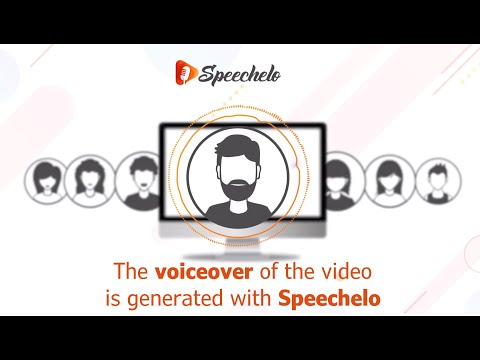

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo(video_id)

In [ ]:
YouTubeTranscriptApi.get_transcript(video_id)
transcript = YouTubeTranscriptApi.get_transcript(video_id)

In [ ]:
transcript[0:5]

[{'text': 'hey', 'start': 0.16, 'duration': 3.2},
 {'text': "i'm joey and i'm one of the 30 ai voices",
  'start': 0.88,
  'duration': 3.919},
 {'text': 'from speech love', 'start': 3.36, 'duration': 3.2},
 {'text': 'you listen to this video until now and',
  'start': 4.799,
  'duration': 3.281},
 {'text': "you probably couldn't tell i'm not a",
  'start': 6.56,
  'duration': 3.2}]

In [ ]:
result = ""
for i in transcript:
    result += ' ' + i['text']
#print(result)
print(len(result))

2725


In [ ]:
print(result)

 for Germany it's the end of an era and as Europe's biggest economy there are some huge challenges ahead from its increasingly complex relationship with China to climate change all eyes will be on how Germany's new leaders grapple with these issues but there's one German industry that reveals a lot about the country's prospects it's cars traditionally the car industry here has been very powerful there have been open doors to German Ministries to the Chancery Germany's car industry is a vital part of its economy with links to government that go back decades how this world renowned motor industry navigates the challenges ahead could tell you more than you think about Germany's future [Music] the curves the Precision it's Cutting Edge engineering like this that has helped Place car makers at the heart of the German economy and the industry has proved of Bellwether for the country's future prospects too since the 70s car exports have risen with Germany's wealth and influence manufacturing 

In [ ]:
pipe_out = pipe(result[0])
print(pipe_out)

Your max_length is set to 128, but your input_length is only 1. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=0)


[{'summary_text': "It's been a long time since we've been able to talk about the many reasons why it's so hard to find the right answer to the question of why it's so hard to find the right answer."}]


In [ ]:
print("Summary is: ", pipe_out[0]['summary_text'])

Summary is:  It's been a long time since we've been able to talk about the many reasons why it's so hard to find the right answer to the question of why it's so hard to find the right answer.


In [ ]:
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
num_iters = int(len(result)/1000)
summarized_text = []
for i in range(0, num_iters + 1):
  start = 0
  start = i * 1000
  end = (i + 1) * 1000
  print("input text \n" + result[start:end])
  out = summarizer(result[start:end])
  out = out[0]
  out = out['summary_text']
  print("Summarized text\n"+out)
  summarized_text.append(out)

input text 
 hey i'm joey and i'm one of the 30 ai voices from speech love you listen to this video until now and you probably couldn't tell i'm not a real human voice that's because i understand exactly what each phrase is saying and i know how to put inflections in my voice just like a real human would do with speechless you can generate as many voiceovers as you want with only three clicks click number one just paste the text you want to be transformed into speech in our online text editor click number two choose the language and voice that you want to use we offer male female and even kids voices and finally click number three click on generate and in five seconds your voiceover is ready to be downloaded how cool is that we offer voices that are perfect for training videos voices that are perfect for presentation videos and voices that sound like hollywood movie trailers and even kid voices that sound joyful and innocent all our voices have elements that make a voice sound real and

In [ ]:
str(summarized_text)

'[\' You can generate as many voiceovers as you want with only three clicks click number one just paste the text you want to be transformed into speech in our online text editor . Click number three click on generate and in five seconds your voiceover is ready to be downloaded how cool is that we offer voices that are perfect for training videos, movie trailers and even kids voices .\', " 98 of the people hearing a voice over generated with speech low can\'t tell it\'s not a real human voice . The creation of a single voice-over will cost you more than the price of this offering . The first 1000 people to join get the special founders offer you can get speech a low for a ridiculously low one-time fee and no monthly recurrence .", \' Click the buy now button below and profit from the one-time payment offer and the huge discount that we have for the first 1000 users . Remember you are covered by our 60-day money-back guarantee [Music] you will refund all your money and let you keep the v